## self organizing maps project description

The goal is to identify the leading patterns of geopotential height for two forms of land-atmosphere feedbacks, dry coupling afternoon precipitation events and wet coupling afternoon precipitation events, in order to determine whether there are large-scale factors which create the preconditions to support these land-surface feedbacks. 

In [25]:
import pandas as pd
from datetime import date
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle
import glob
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import os
import re
from datetime import datetime, timedelta
from haversine import haversine, Unit
import metpy
import metpy.constants as mpconst
import metpy.units as units
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
from matplotlib.patches import Rectangle
from pydoc import help
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [26]:
with open('geosom.pkl', 'rb') as f:
    
    geosom = pickle.load(f)

geosom.rename_axis('day', axis='index', inplace=True)

geosom.reset_index(inplace=True)

geosom.rename(columns={'daily_mean': 'z500'}, inplace=True)

#splitting into labels & features, where labels = dry coupling or wet coupling and features is geopotential height

labels_df = geosom[['day','dry_coupling','wet_coupling', 'APE']].drop_duplicates(keep='first')

labels_df.reset_index(drop=True, inplace=True)

labels = labels_df.iloc[:,1:].values

features = geosom[['day','lat','lon','z500']]

In [27]:
#restructuring features such that there is a unique combination of latitude and longitude as its own column
#so that there is one row for each day 
#latitude range: 25 --> 50, longitude range: 70 --> 120

X_feat = features.pivot_table(index='day', columns=['lat', 'lon'], values=['z500'])

X_feat.reset_index(inplace=True)

#flattening the MultiIndex column names

X_feat.columns = [''.join(map(str, col)) for col in X_feat.columns]

X = X_feat.iloc[:, 1:].values

#after restructuring features into X_feat, combining into a single dataframe for later use
#data has shape 160 x 1329 (160 days, 1329 latitude, longitude pairs)
data = pd.merge(X_feat, labels_df, on='day', how='inner')

In [28]:
# calculated standardized anamolies: x - mean (of feature)/standard deviation (of feature)
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [29]:
# hyperparameter options
#although 30 x 30 created a very small QE, the SOM was too large for my dataset which resulted in overfitting

param_grid = {
    'x': [4],
    'y': [4],
    'learning_rate': [0.01, 0.1, 0.25, 0.5, 1],
    'sigma': [0.1, 0.5, 1.0, 1.5, 2]
}

# all combinations of hyperparameters
grid = ParameterGrid(param_grid)

# initialize variables to track the best configuration
best_params = None

best_quantization_error = float('inf')

# function to calculate quantization error: measures the average distance between each data point and its corresponding BMU in the SOM

def quantization_error(som, data):
    
    error = 0
    
    for x in data:
        
        #difference between x (from x_scaled) and weights for the winning node, then take the norm of that vector to get the total distance
        error += np.linalg.norm(x - som.get_weights()[som.winner(x)])
    
    #for each SOM, calculate the average QE
    return error / len(data)

# # grid search

for params in grid:
    
    som = MiniSom(x=params['x'], y=params['y'], input_len=X_scaled.shape[1], sigma=params['sigma'], learning_rate=params['learning_rate'])
    
    som.random_weights_init(X_scaled)
    
    som.train_random(data=X_scaled, num_iteration=10000)
    
    qe = quantization_error(som, X_scaled)
    
#     print(f"Params: {params}, Quantization Error: {qe}")
    
    #best_quantization_error starts at infinity, then with each subsequent QE calculation, updates best QE & params if new QE is less than previous QE 
    
    if qe < best_quantization_error:
        
        best_quantization_error = qe
        
        best_params = params

print(f"Best params: {best_params}, Best Quantization Error: {best_quantization_error}")


Best params: {'learning_rate': 0.1, 'sigma': 0.5, 'x': 4, 'y': 4}, Best Quantization Error: 28.119924887965475


In [30]:
#hyperparameters

np.random.seed(42)

n_rows = best_params['x']

n_columns = best_params['y']

sigma = best_params['sigma']

learning_rate = best_params['learning_rate']

som = MiniSom(n_rows, n_columns, X_scaled.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=42)

som.random_weights_init(X_scaled)

#add verbose = True if you want more detail

som.train_random(X_scaled, 10000)

In [31]:
# creating a bmu column to assign each day to the bmu according to SOM result

bmus = []

for x in X_scaled:
    
    bmu = som.winner(x)
    
    bmus.append(bmu)
    
    
data['bmu'] = bmus

## SOM result without cartopy

In [49]:
max_weight = np.max(som.get_weights())

min_weight = np.min(som.get_weights())

color_bar_max = max(abs(max_weight), abs(min_weight))

color_bar_min = -color_bar_max

weights = som.get_weights()

som_dim_x, som_dim_y, num_features = weights.shape

sgp_lon_min, sgp_lon_max = 262, 263

sgp_lat_min, sgp_lat_max = 36, 37

latitude_size = 26

longitude_size = 80

latitudes = np.linspace(25, 50, latitude_size)

longitudes = np.linspace(220, 299, longitude_size)

lon, lat = np.meshgrid(longitudes, latitudes)

norm = TwoSlopeNorm(vmin=color_bar_min, vcenter=0, vmax=color_bar_max)

total_samples = len(X_scaled)

grid_size = int(np.ceil(np.sqrt(som_dim_x * som_dim_y)))

frequency_map = np.zeros((som_dim_x, som_dim_y))

for x in X_scaled:
    
    w = som.winner(x)
    
    frequency_map[w] += 1

## Plotting SOM with Cartopy --> full result

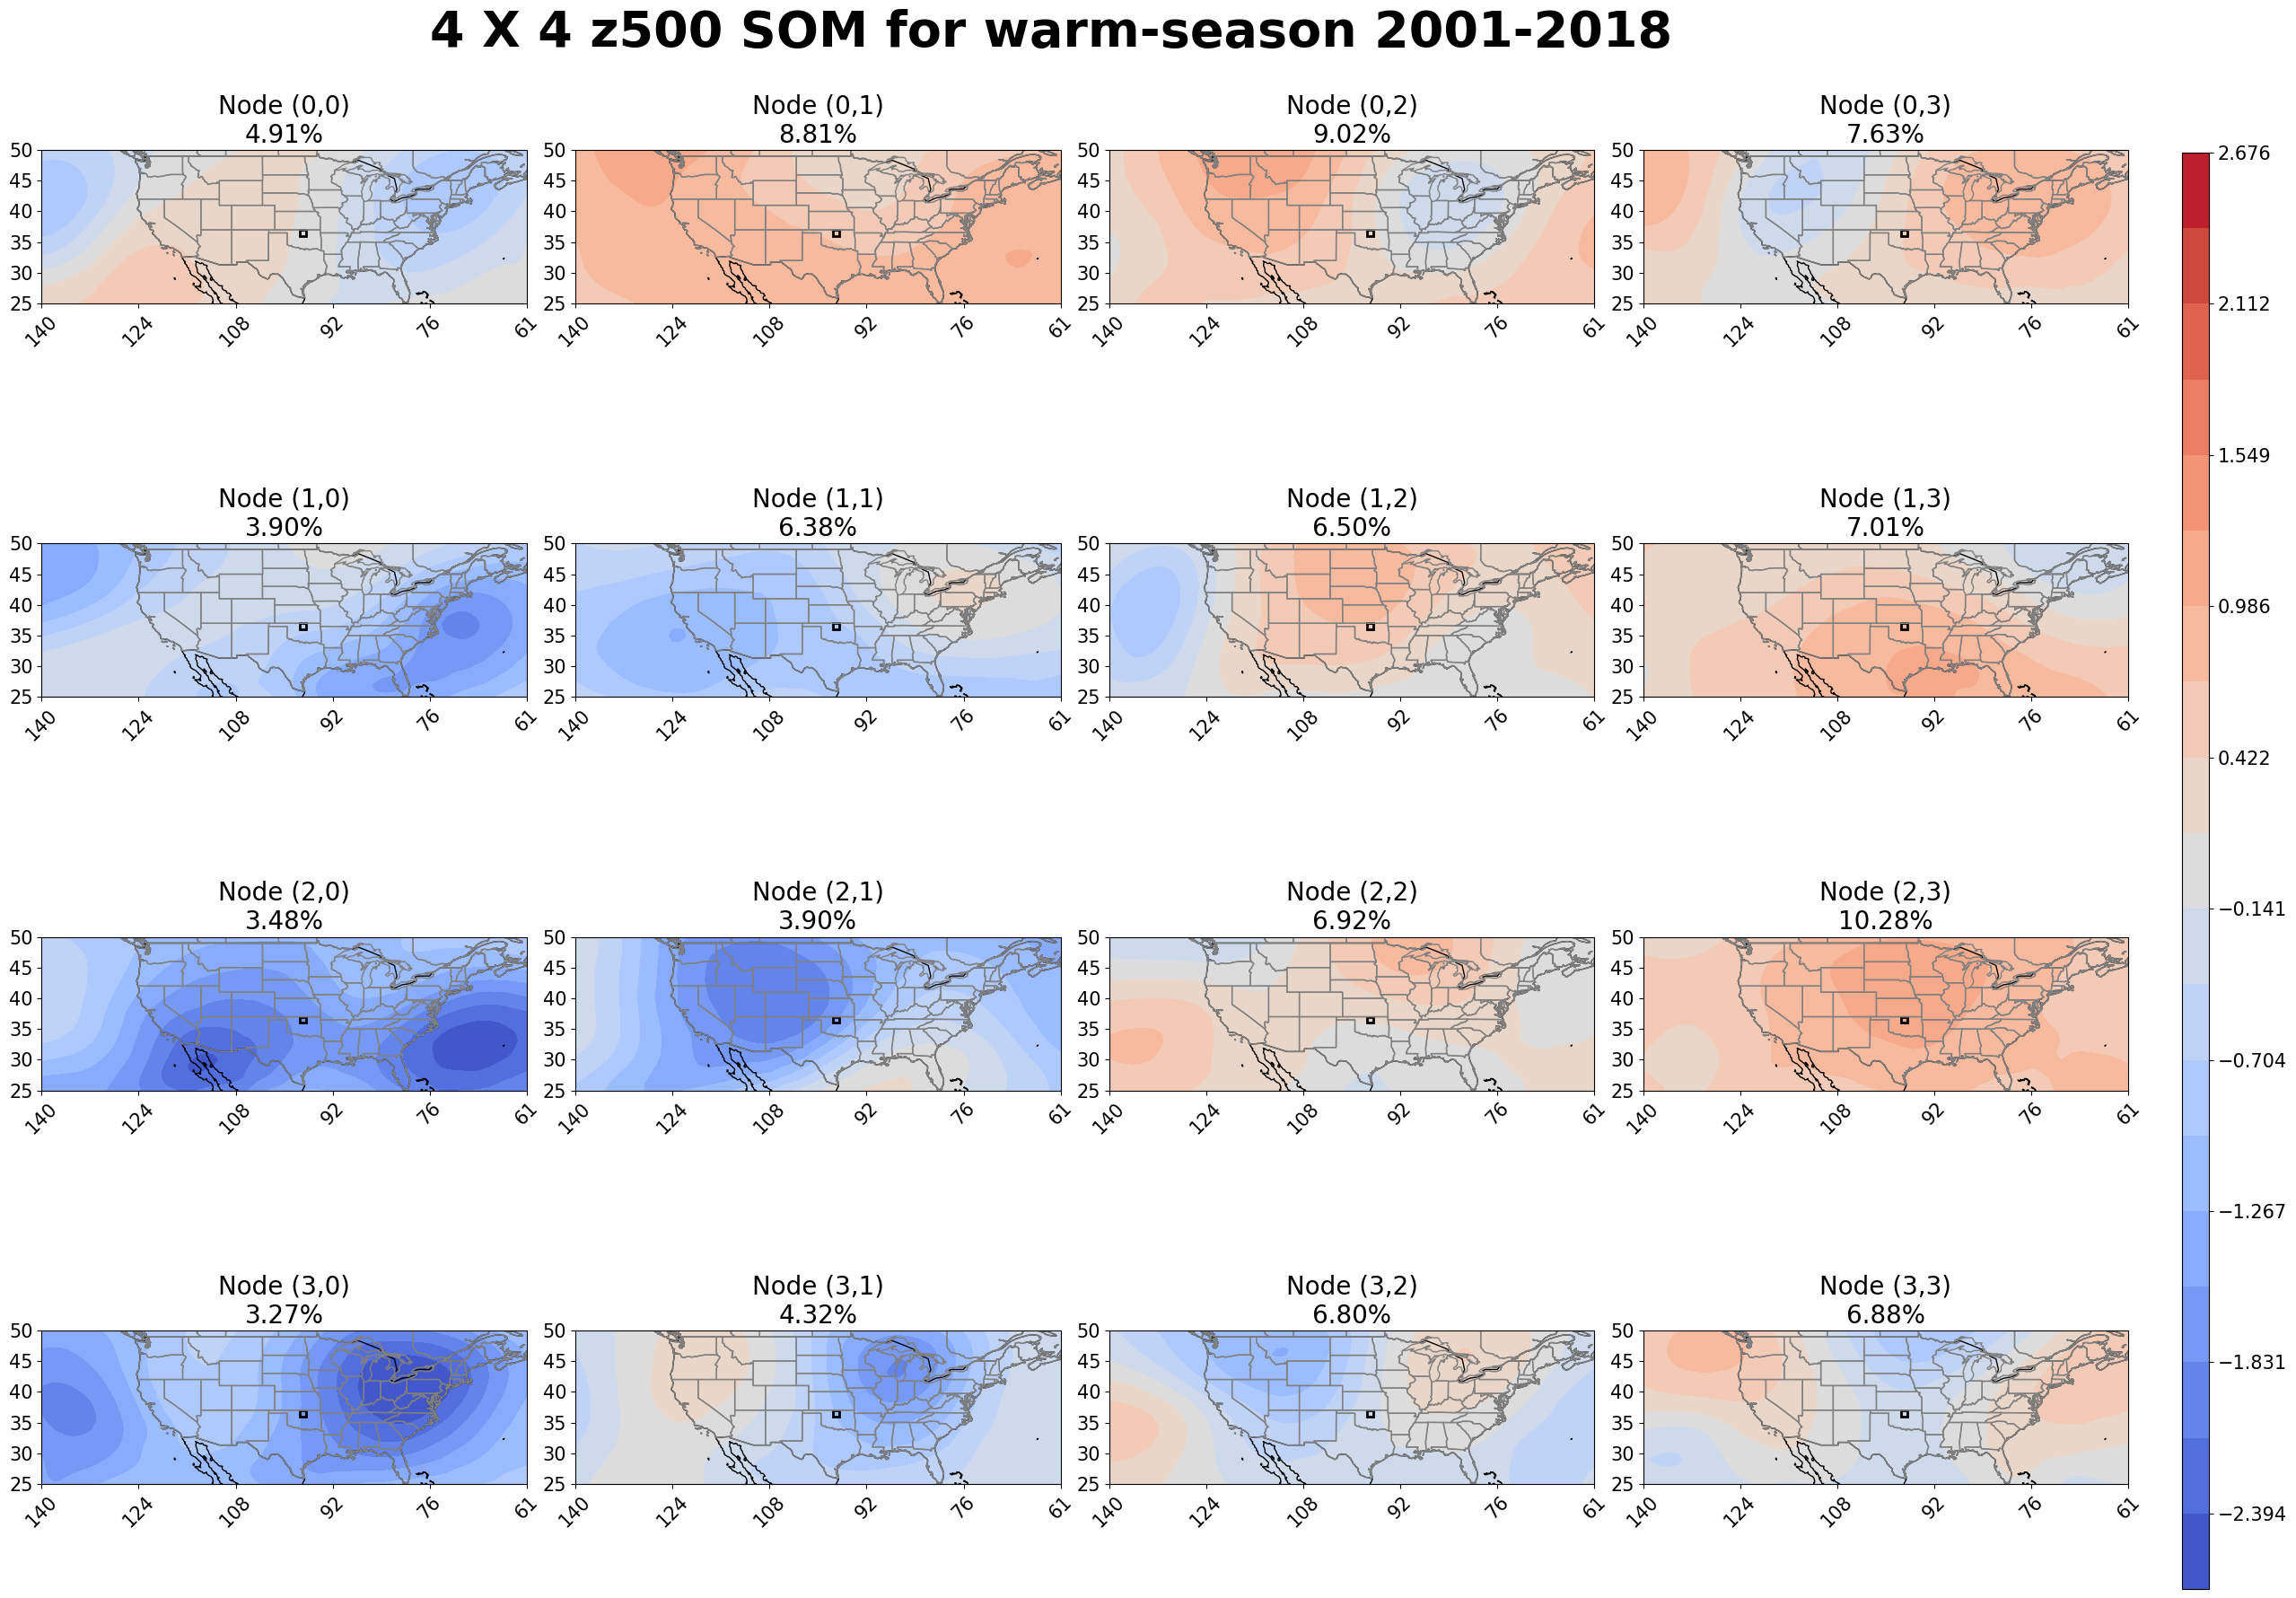

In [50]:
fig = plt.figure(figsize=(30, 20))

gs = GridSpec(som_dim_x, som_dim_y, figure=fig, height_ratios=np.ones(som_dim_x), width_ratios=np.ones(som_dim_y), wspace=0.1, hspace=0.2)

for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        
        ax.set_extent([220, 299, 25, 50], crs=ccrs.PlateCarree())

        # Reshape the weight vector back into the original grid shape
        geopotential_height = weights[i, j, :].reshape((latitude_size, longitude_size))
        
        #ax.contourf(x, y, data, ....)
        cont = ax.contourf(lon, lat, geopotential_height, cmap='coolwarm', levels=np.linspace(color_bar_min, color_bar_max, 20), norm=norm)

        # add geography
        ax.add_feature(cfeature.COASTLINE)
        
        ax.add_feature(cfeature.BORDERS)
        
        ax.add_feature(cfeature.STATES, edgecolor='gray')

        # Calculate the frequency of each BMU percentage
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100

        ax.set_title(f'Node ({i},{j})\n{frequency_percentage:.2f}%', fontsize=20)

        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, 
                            sgp_lat_max - sgp_lat_min, edgecolor='black', 
                            facecolor='none', linewidth=2, transform=ccrs.PlateCarree())

        ax.add_patch(sgp_box)
        
        ax.set_xticks(np.linspace(-140, -61, 6))  # Set longitude ticks
        
        ax.set_yticks(np.linspace(25, 50, 6))   # Set latitude ticks
        
        ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=15)
        
        ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=15)

# create a new axis for the colorbar
cax = fig.add_axes([0.92, 0.1, 0.01, 0.8])

cbar = fig.colorbar(cont, cax=cax, orientation='vertical')

# Set colorbar tick labels font size
cbar.ax.tick_params(labelsize=15)

plt.subplots_adjust(top=0.95)

plt.suptitle("4 X 4 z500 SOM for warm-season 2001-2018", fontsize=40, fontweight='bold')

plt.show()


## Plotting SOM with cartopy --> individual plots

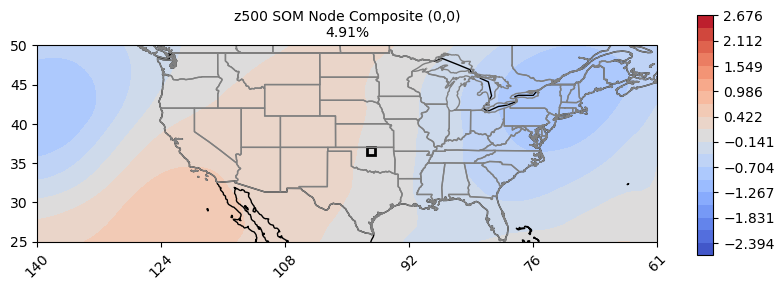

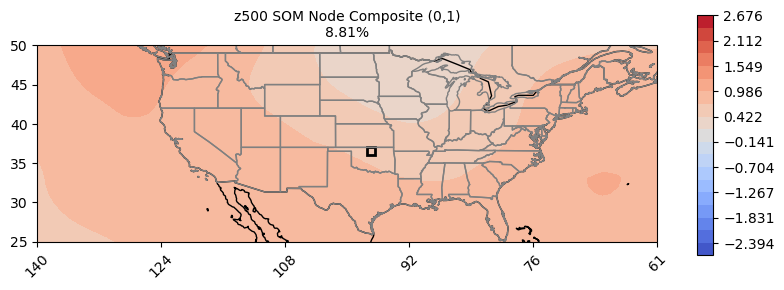

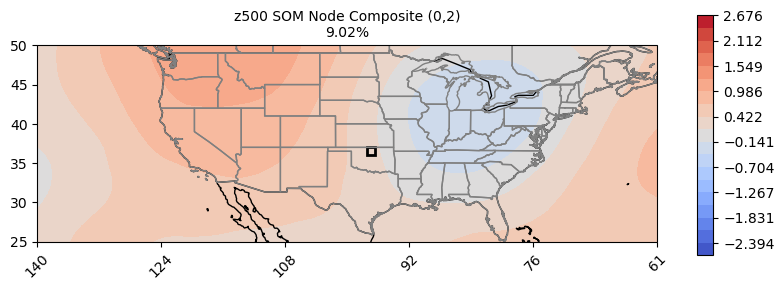

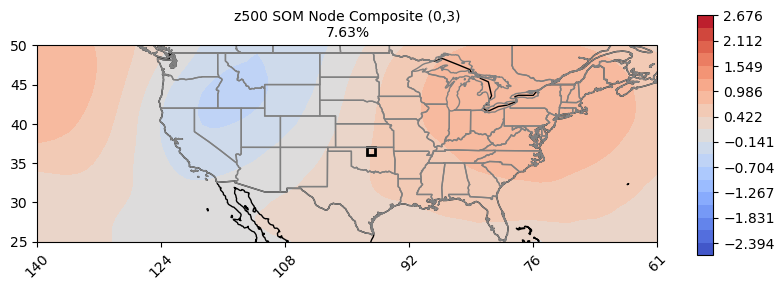

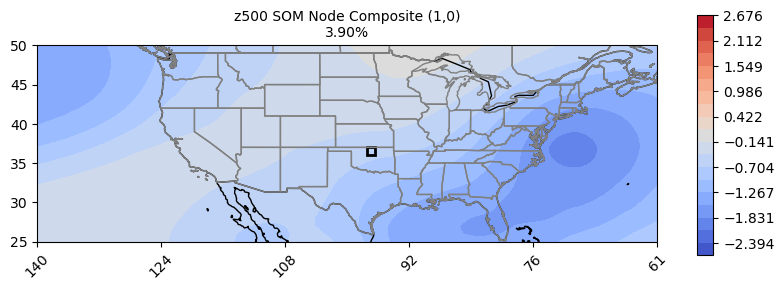

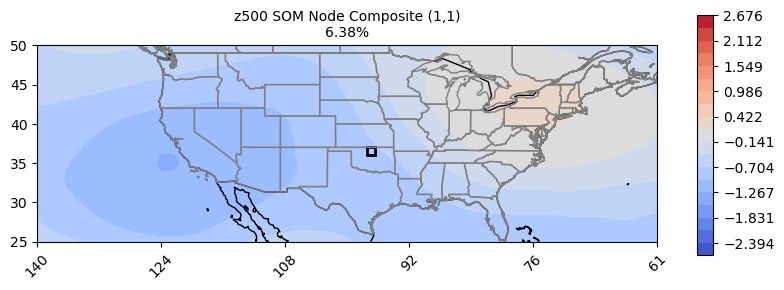

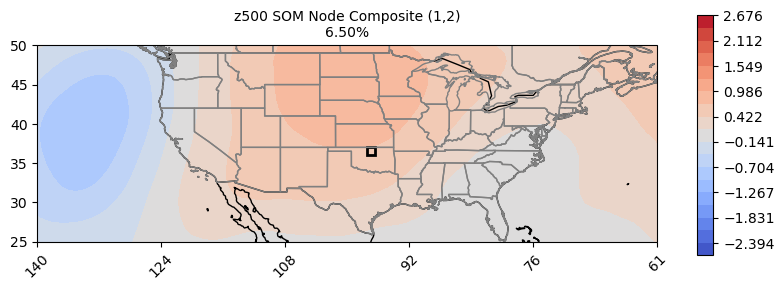

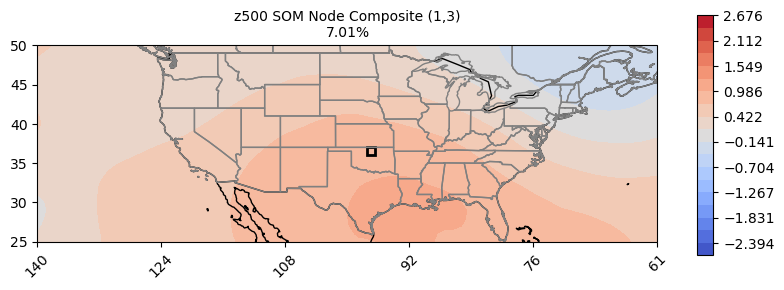

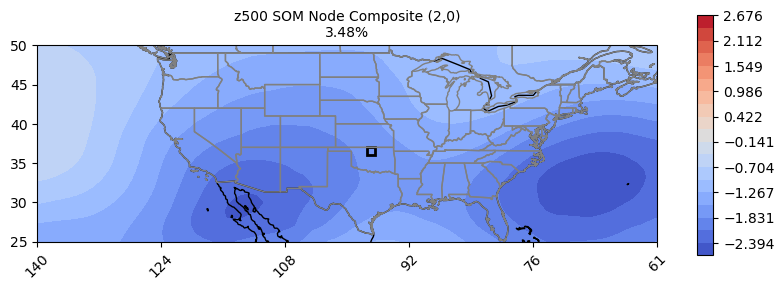

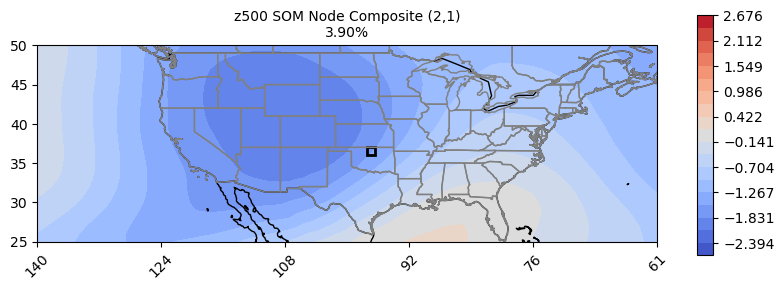

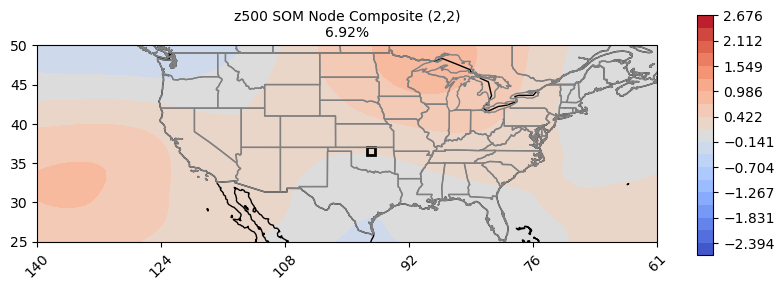

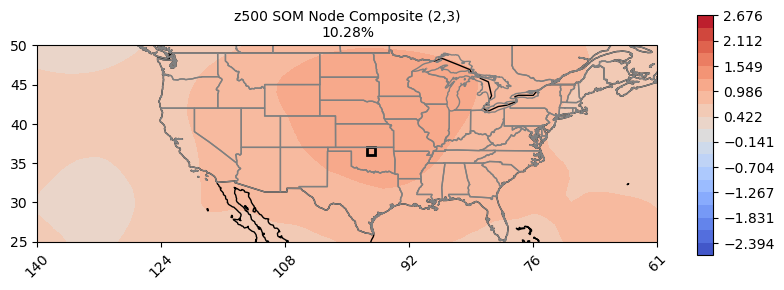

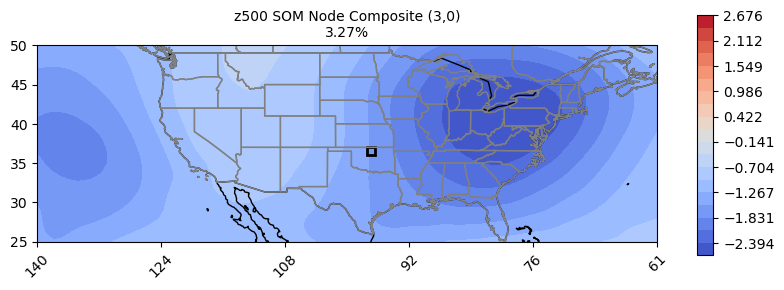

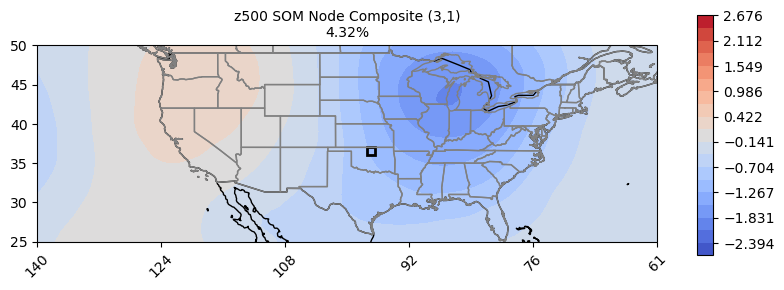

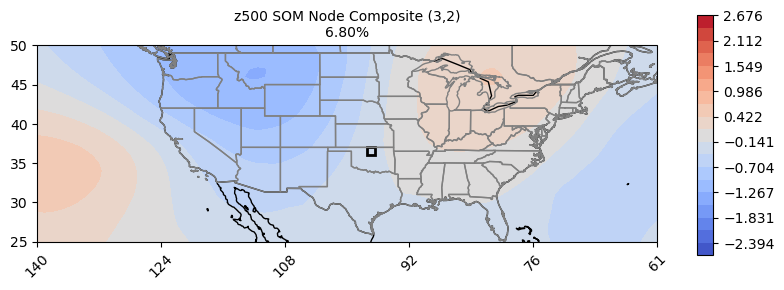

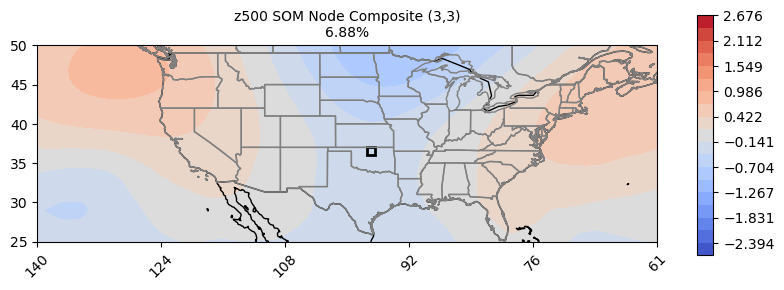

In [51]:
fig_size = (8, 4)

for i in range(som_dim_x):
    
    for j in range(som_dim_y):
        
        fig, ax = plt.subplots(1, 1, figsize=fig_size, subplot_kw={'projection': ccrs.PlateCarree()})
        
        ax.set_extent([220, 299, 25, 50], crs=ccrs.PlateCarree())

        # Reshape the weight vector back into the original grid shape
        geopotential_height = weights[i, j, :].reshape((latitude_size, longitude_size))
        
        # Plot the contour
        cont = ax.contourf(lon, lat, geopotential_height, cmap='coolwarm', levels=np.linspace(color_bar_min, color_bar_max, 20), norm=norm)

        # Add geographical features
        ax.add_feature(cfeature.COASTLINE)
        
        ax.add_feature(cfeature.BORDERS)
        
        ax.add_feature(cfeature.STATES, edgecolor='gray')

        # Calculate the frequency of each BMU percentage
        frequency_percentage = (frequency_map[i, j] / total_samples) * 100

        ax.set_title(f'z500 SOM Node Composite ({i},{j})\n{frequency_percentage:.2f}%', fontsize=10)

        # Add bounding box for the SGP region
        sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, 
                            sgp_lat_max - sgp_lat_min, edgecolor='black', 
                            facecolor='none', linewidth=2, transform=ccrs.PlateCarree())
        
        ax.add_patch(sgp_box)
        
        # Set ticks and labels
        ax.set_xticks(np.linspace(-140, -61, 6))  # Set longitude ticks
        
        ax.set_yticks(np.linspace(25, 50, 6))   # Set latitude ticks
        
        ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=10)
        
        ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=10)

        # Create a new axis for the colorbar and center it next to the plot
        cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])  # [left, bottom, width, height] for vertical colorbar
        
        cbar = fig.colorbar(cont, cax=cax, orientation='vertical')

        # Set colorbar tick labels font size
        cbar.ax.tick_params(labelsize=10)

        plt.subplots_adjust(top=0.85)

        # Show the plot
        plt.show()


## Plotting IVT composite per SOM --> full result

In [43]:
#reading in IVT information to create composite with SOM result

with open('ivt_flat.pkl', 'rb') as f:
    
    daily_ivt = pickle.load(f)
    
#creating df which only includes day and bmu for IVT composite
bmu_per_day = data.set_index("day")

bmu_per_day = bmu_per_day['bmu']

#merge bmu & ivt
daily_ivt_with_bmu = pd.merge(daily_ivt, bmu_per_day, left_index=True, right_index=True)

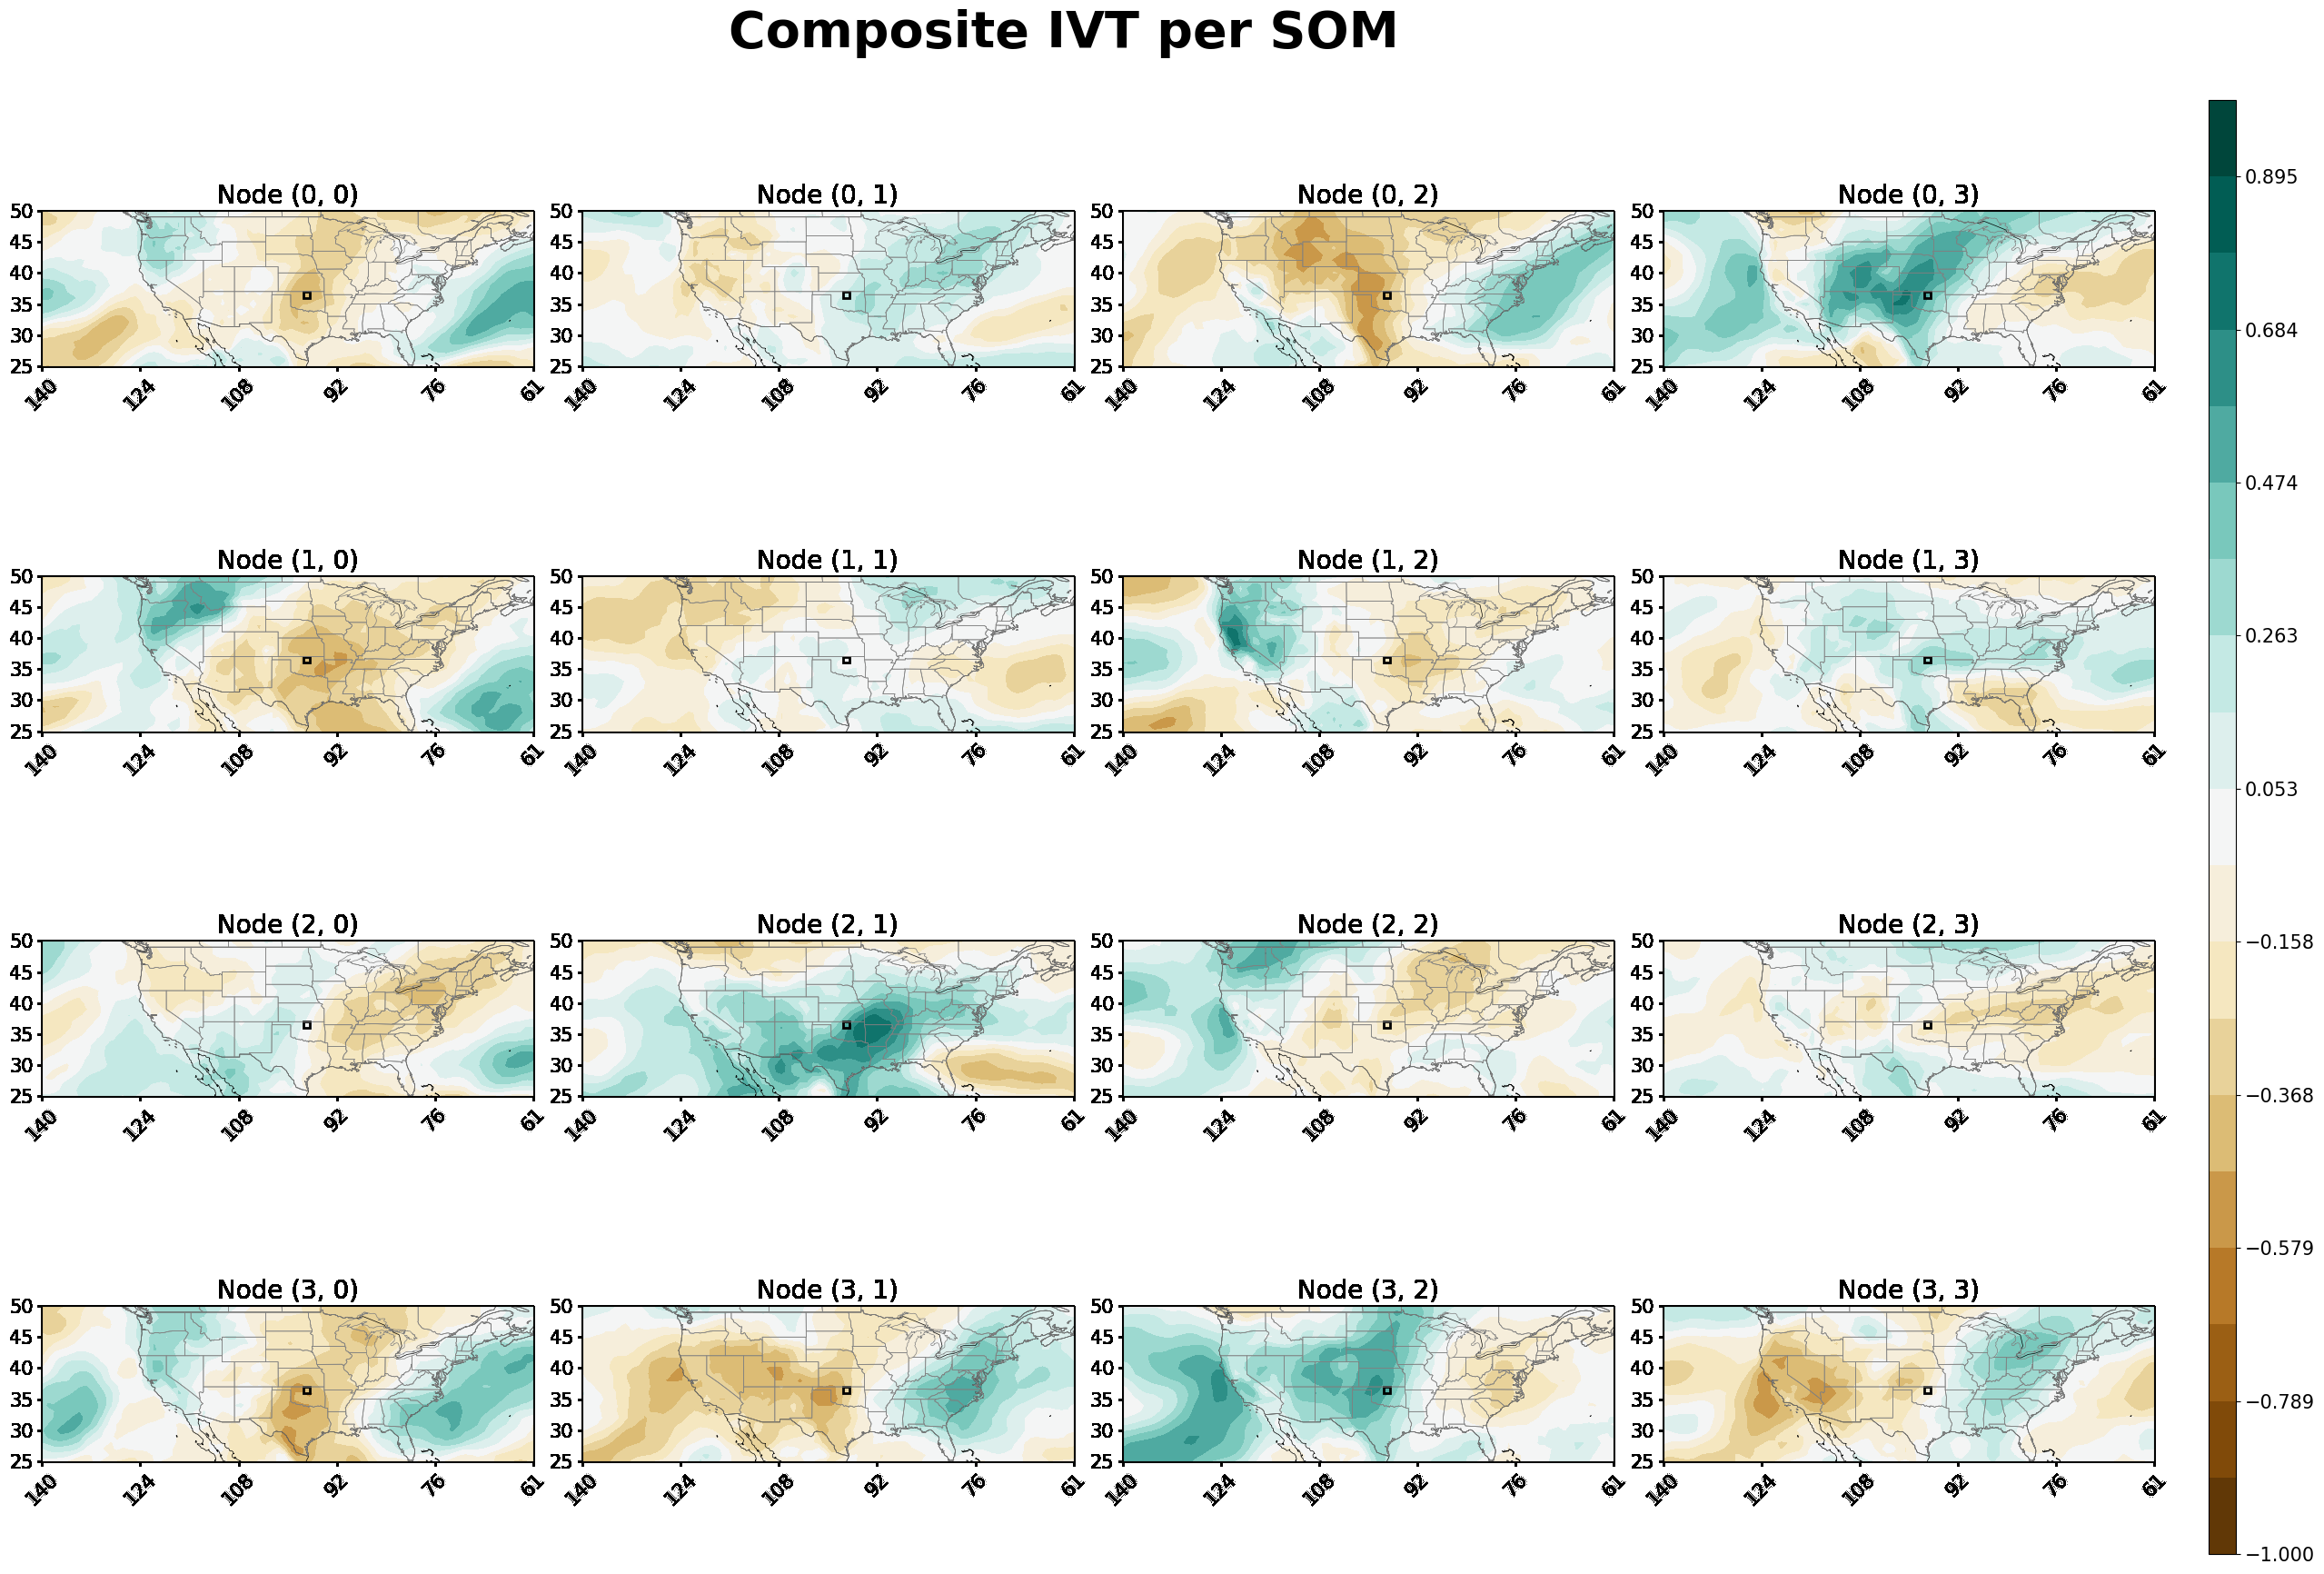

In [45]:
color_bar_min_ivt = -1

color_bar_max_ivt = 1

fig = plt.figure(figsize=(30, 20))

gs = GridSpec(som_dim_x, som_dim_y, figure=fig, height_ratios=np.ones(som_dim_x), width_ratios=np.ones(som_dim_y), wspace=0.1, hspace=0.2)

fig.suptitle("Composite IVT per SOM", fontsize=40, fontweight='bold', x=0.5, y=0.95)

all_bmus = daily_ivt_with_bmu['bmu'].values

for idx, bmu in enumerate(all_bmus):
    
    row, col = bmu
    
    bmu_data = daily_ivt_with_bmu[(daily_ivt_with_bmu['bmu'] == bmu)]
    
    # calculate mean IVT values for each column 
    
    mean_ivt = bmu_data.iloc[:, :-1].mean()
    
    ivt_grid = mean_ivt.values.reshape((latitude_size, longitude_size))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
    
    cont = ax.contourf(longitudes, latitudes, ivt_grid, cmap='BrBG', levels=np.linspace(color_bar_min_ivt, color_bar_max_ivt, 20))
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)

    ax.set_title(f'Node {bmu}', fontsize=20)
    

    sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                        edgecolor='black', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())
    
    ax.add_patch(sgp_box)
    
    ax.set_xticks(np.linspace(-140, -61, 6))
    
    ax.set_xticklabels(np.linspace(140, 61, 6).astype(int), rotation=45, fontsize=15)
    
    ax.set_yticks(np.linspace(25, 50, 6))
    
    ax.set_yticklabels(np.linspace(25, 50, 6).astype(int), fontsize=15)

    
cax = fig.add_axes([0.92, 0.1, 0.01, 0.8]) 

cbar = fig.colorbar(cont, cax=cax, orientation='vertical')

cbar.ax.tick_params(labelsize=15)

plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.show()


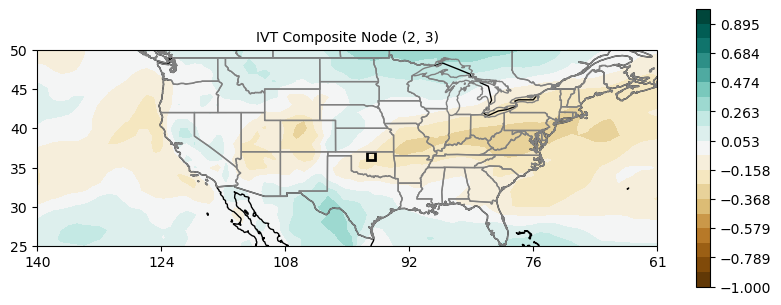

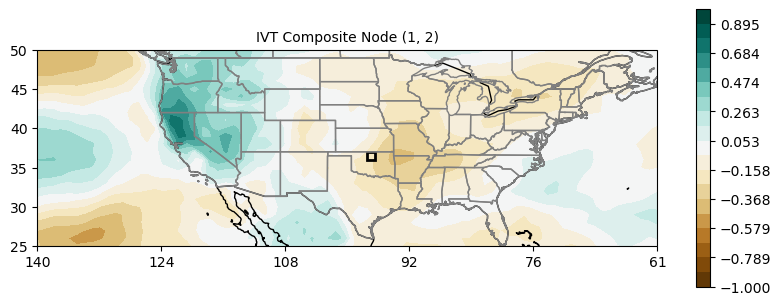

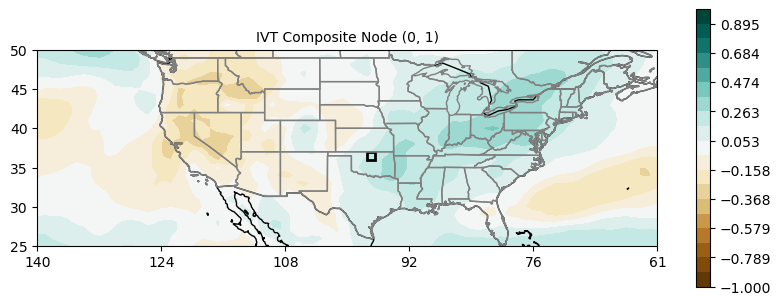

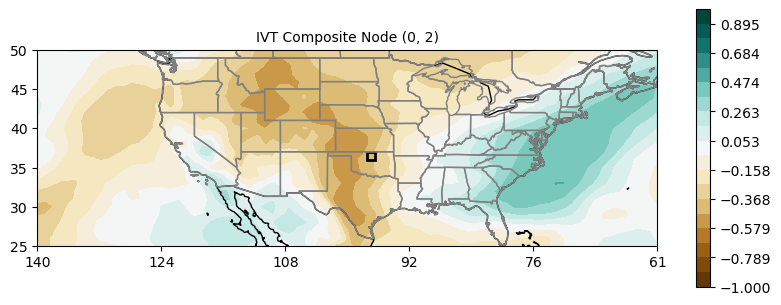

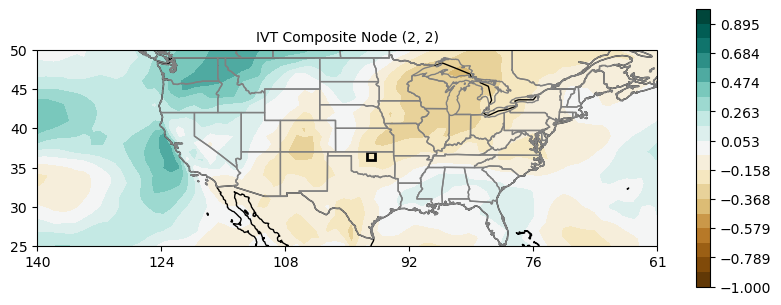

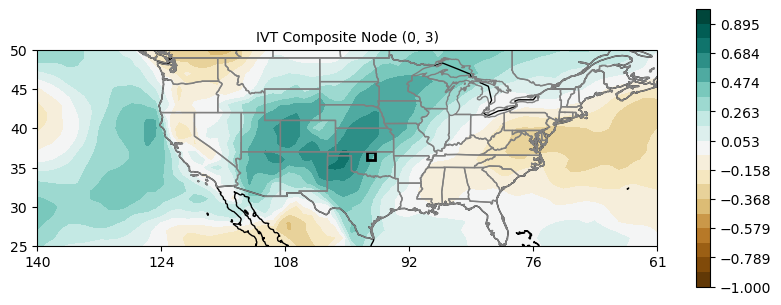

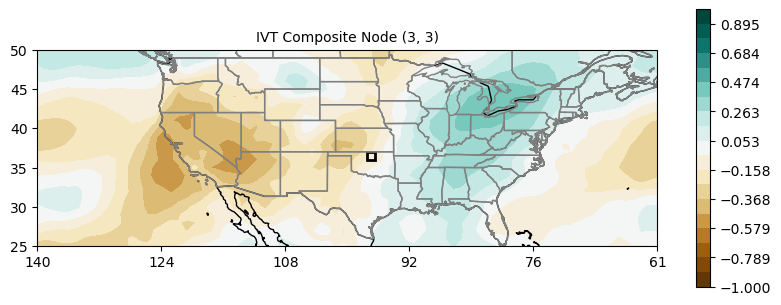

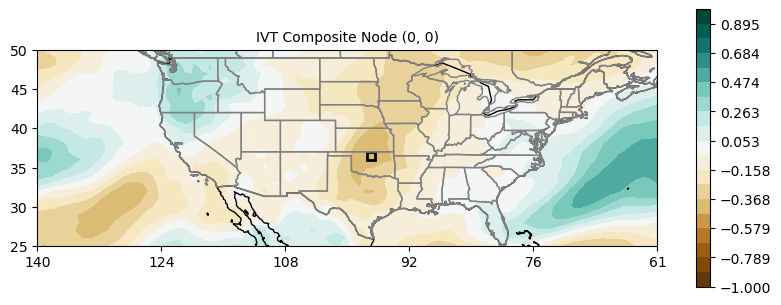

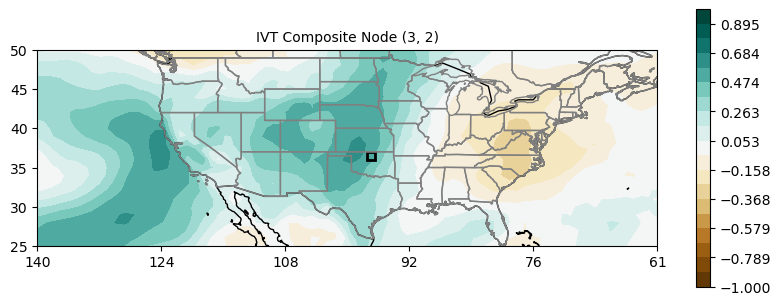

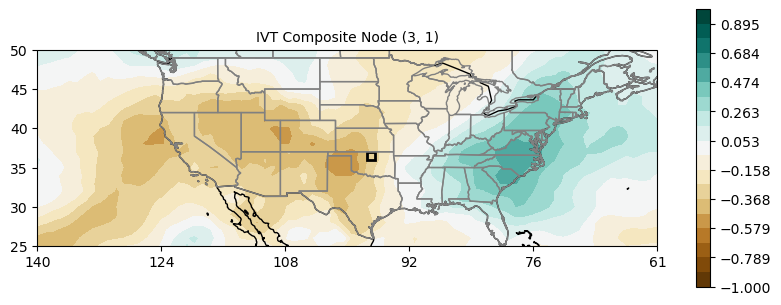

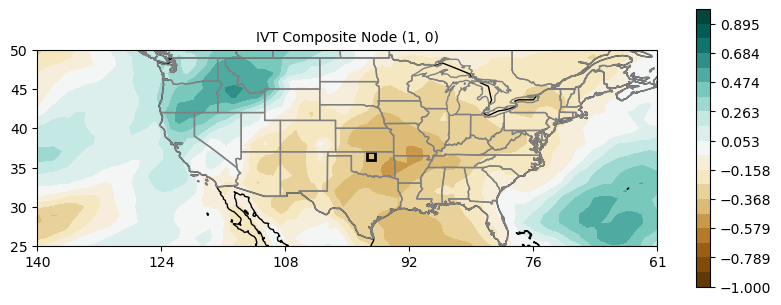

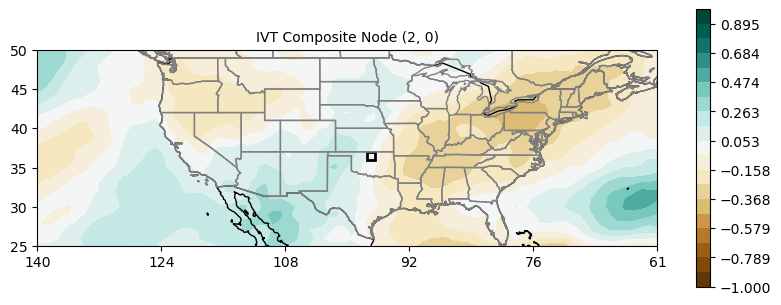

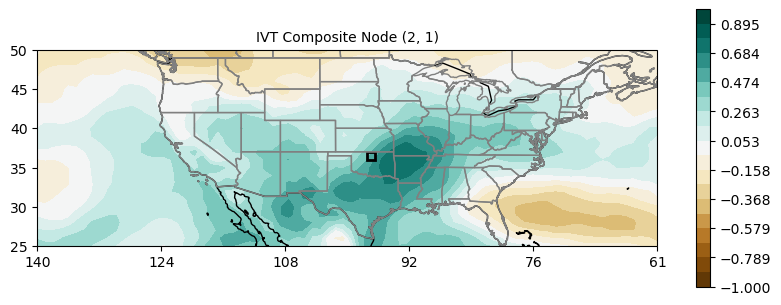

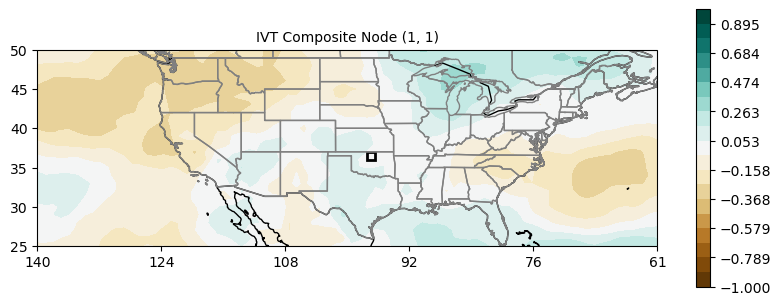

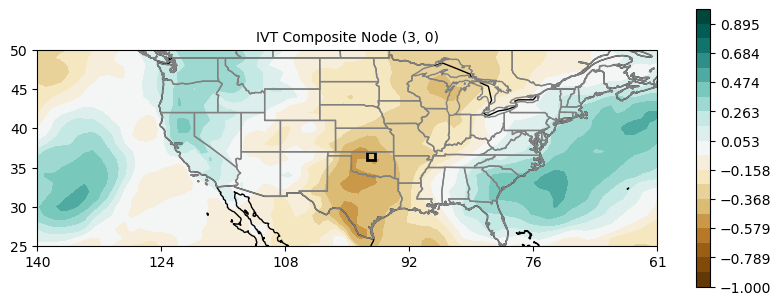

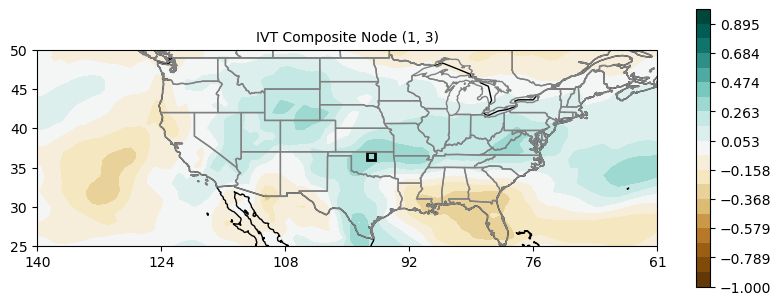

In [46]:
color_bar_min_ivt = -1

color_bar_max_ivt = 1

all_bmus = daily_ivt_with_bmu['bmu'].unique()

for bmu in all_bmus:
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    row, col = bmu
    
    bmu_data = daily_ivt_with_bmu[daily_ivt_with_bmu['bmu'] == bmu]
    
    mean_ivt = bmu_data.iloc[:, :-1].mean()
    
    ivt_grid = mean_ivt.values.reshape((latitude_size, longitude_size))
    
    cont = ax.contourf(longitudes, latitudes, ivt_grid, cmap='BrBG', levels=np.linspace(color_bar_min_ivt, color_bar_max_ivt, 20))
    
    # Add geographical features
    ax.add_feature(cfeature.COASTLINE)
    
    ax.add_feature(cfeature.BORDERS)
    
    ax.add_feature(cfeature.STATES, edgecolor='gray')
    
    # Add title
    ax.set_title(f'IVT Composite Node {bmu}', fontsize=10)
    
    # Add bounding box for the SGP region
    sgp_box = Rectangle((sgp_lon_min, sgp_lat_min), sgp_lon_max - sgp_lon_min, sgp_lat_max - sgp_lat_min,
                        edgecolor='black', facecolor='none', linewidth=2, transform=ccrs.PlateCarree())
    ax.add_patch(sgp_box)
    
    # Set ticks and labels
    ax.set_xticks(np.linspace(-140, -61, 6))
    
    ax.set_xticklabels(np.linspace(140, 61, 6).astype(int))
    
    ax.set_yticks(np.linspace(25, 50, 6))
    
    ax.set_yticklabels(np.linspace(25, 50, 6).astype(int))
    
    # Add a color bar for the current figure
    cbar = fig.colorbar(cont, ax=ax, orientation='vertical', shrink=0.6, pad=0.05)
    
    cbar.ax.tick_params(labelsize=10)
    
    plt.show()


## Analyzing frequency of BMU node per category

In [38]:
data['dry_coup_ape'] = data['dry_coupling'] & data['APE']

data['wet_coup_ape'] = data['wet_coupling'] & data['APE']

In [39]:
bmucounts = data['bmu'].value_counts().to_frame().rename(columns={'bmu': 'bmu_count'})

bmu_grouped = data.groupby('bmu')

#dry coupling
drycounts = bmu_grouped['dry_coupling'].sum().to_frame().rename(columns={'dry_coupling': 'dry_coup_count'})

#wet coupling
wetcounts = bmu_grouped['wet_coupling'].sum().to_frame().rename(columns={'wet_coupling': 'wet_coup_count'})

total_coupling_counts = pd.merge(pd.merge(bmucounts, drycounts, left_index=True, right_index=True), wetcounts, left_index=True, right_index=True)

total_coupling_counts['dry_perc'] = (total_coupling_counts['dry_coup_count']/total_coupling_counts['bmu_count'])*100

total_coupling_counts['wet_perc'] = (total_coupling_counts['wet_coup_count']/total_coupling_counts['bmu_count'])*100

total_coupling_counts['bmu_perc'] = (total_coupling_counts['bmu_count']/data.shape[0])*100

total_coupling_counts['remainder_perc'] = 100 - (total_coupling_counts['dry_perc']+total_coupling_counts['wet_perc'])

In [40]:
#dry coupling APE
dryapecounts = bmu_grouped['dry_coup_ape'].sum().to_frame().rename(columns={'dry_coup_ape': 'dry_coup_ape_count'})

#wet coupling APE 
wetapecounts = bmu_grouped['wet_coup_ape'].sum().to_frame().rename(columns={'wet_coup_ape': 'wet_coup_ape_count'})

total_coupling_ape_counts = pd.merge(pd.merge(bmucounts, dryapecounts, left_index=True, right_index=True), wetapecounts, left_index=True, right_index=True)

total_coupling_ape_counts['dry_ape_perc'] = (total_coupling_ape_counts['dry_coup_ape_count']/total_coupling_ape_counts['bmu_count'])*100

total_coupling_ape_counts['wet_ape_perc'] = (total_coupling_ape_counts['wet_coup_ape_count']/total_coupling_ape_counts['bmu_count'])*100

total_coupling_ape_counts['bmu_perc'] = (total_coupling_ape_counts['bmu_count']/data.shape[0])*100

total_coupling_ape_counts['remainder_perc'] = 100 - (total_coupling_ape_counts['dry_ape_perc']+total_coupling_ape_counts['wet_ape_perc'])


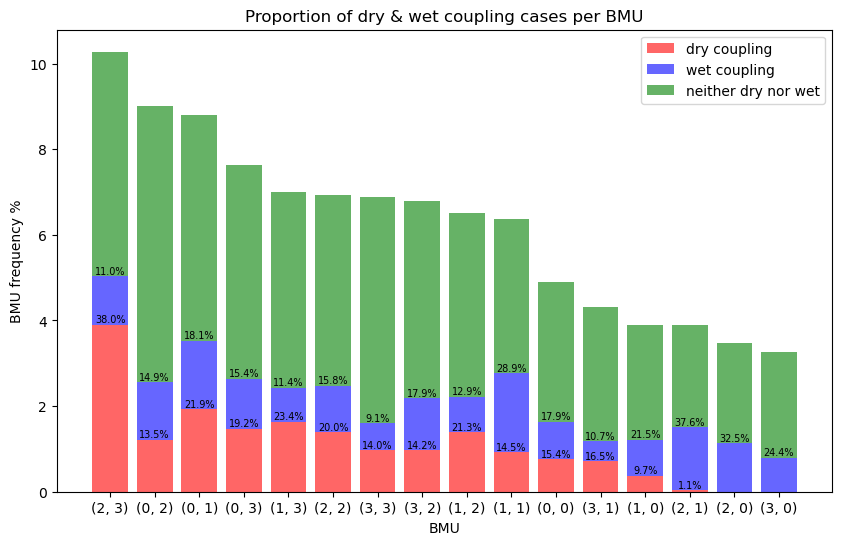

In [41]:
# Convert index to strings for plotting
total_coupling_counts.index = total_coupling_counts.index.map(str)

# Calculate the actual heights for stacking
dry_heights = total_coupling_counts['bmu_perc'] * total_coupling_counts['dry_perc'] / 100

wet_heights = total_coupling_counts['bmu_perc'] * total_coupling_counts['wet_perc'] / 100

remainder_heights = total_coupling_counts['bmu_perc'] * total_coupling_counts['remainder_perc'] / 100

# Calculate the bottom values for stacking
bottom_wet = dry_heights

bottom_remainder = bottom_wet + wet_heights

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each series with stacking
p1 = ax.bar(total_coupling_counts.index, dry_heights, color='red', alpha=0.6, label='dry coupling')

p2 = ax.bar(total_coupling_counts.index, wet_heights, bottom=bottom_wet, color='blue', alpha=0.6, label='wet coupling')

p3 = ax.bar(total_coupling_counts.index, remainder_heights, bottom=bottom_remainder, color='green', alpha=0.6, label='neither dry nor wet')

# Annotate bars with frequency percentages
for i, (dry, wet) in enumerate(zip(total_coupling_counts['dry_perc'], total_coupling_counts['wet_perc'])):
    
    if dry > 0:
        
        ax.text(i, dry_heights[i], f'{dry:.1f}%', ha='center', va='bottom', color='black', size=7)
    
    if wet > 0:
        
        ax.text(i, bottom_wet[i] + wet_heights[i], f'{wet:.1f}%', ha='center', va='bottom', color='black', size=7)

ax.set_xlabel('BMU')

ax.set_ylabel('BMU frequency %')

ax.set_title('Proportion of dry & wet coupling cases per BMU')

ax.legend()

plt.show()

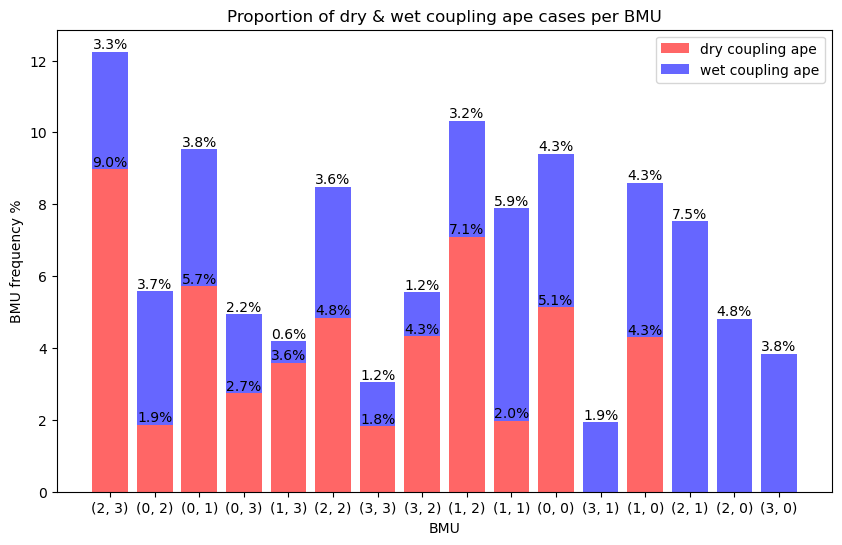

In [42]:
# Convert index to strings for plotting
total_coupling_ape_counts.index = total_coupling_ape_counts.index.map(str)

dry_heights = total_coupling_ape_counts['dry_ape_perc']

wet_heights = total_coupling_ape_counts['wet_ape_perc']

# remainder_heights = total_coupling_ape_counts['bmu_perc'] * total_coupling_ape_counts['remainder_perc'] / 100

# Calculate the bottom values for stacking
bottom_wet = dry_heights

# bottom_remainder = bottom_wet + wet_heights

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each series with stacking
p1 = ax.bar(total_coupling_ape_counts.index, dry_heights, color='red', alpha=0.6, label='dry coupling ape')

p2 = ax.bar(total_coupling_ape_counts.index, wet_heights, bottom=bottom_wet, color='blue', alpha=0.6, label='wet coupling ape')

# p3 = ax.bar(total_coupling_ape_counts.index, remainder_heights, bottom=bottom_remainder, color='green', alpha=0.6, label='neither')

# Annotate bars with frequency percentages
for i, (dry, wet) in enumerate(zip(total_coupling_ape_counts['dry_ape_perc'], total_coupling_ape_counts['wet_ape_perc'])):
    
    if dry > 0:
        
        ax.text(i, dry_heights[i], f'{dry:.1f}%', ha='center', va='bottom', color='black', size=10)
    
    if wet > 0:
        
        ax.text(i, bottom_wet[i] + wet_heights[i], f'{wet:.1f}%', ha='center', va='bottom', color='black', size=10)

ax.set_xlabel('BMU')

ax.set_ylabel('BMU frequency %')

ax.set_title('Proportion of dry & wet coupling ape cases per BMU')

ax.legend()

plt.show()
